In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

BASE = "https://www.jumia.com.eg"
headers = {"User-Agent": "Mozilla/5.0"}

def detect_gender(title):
    t = title.lower()
    if "men" in t or "man " in t or "man's" in t:
        return "Men"
    if "women" in t or "woman" in t or "ladies" in t or "female" in t:
        return "Women"
    if "kid" in t or "boy" in t or "girl" in t:
        return "Kids"
    return "Unisex"

def get_page(url):
    for _ in range(3):
        try:
            r = requests.get(url, headers=headers, timeout=10)
            if r.status_code == 200:
                return r.text
        except:
            time.sleep(1)
    return ""


def get_listing_products(url):
    html = get_page(url)
    soup = BeautifulSoup(html, "html.parser")

    products = []

    for item in soup.select("article.prd"):
        title = item.select_one("div.info h3.name")
        price = item.select_one("div.info .prc")
        old = item.select_one("div.info .old")
        disc = item.select_one("div.info .bdg._dsct")
        link = item.select_one("a.core")

        products.append({
            "title": title.get_text(strip=True) if title else "",
            "price": price.get_text(strip=True) if price else "",
            "preprice": old.get_text(strip=True) if old else "",
            "discount": disc.get_text(strip=True) if disc else "",
            "url": BASE + link["href"] if link else "",
        })

    return products


def get_product_details(url):
    if url == "":
        return {"brand": "", "sku": "", "model": "", "color": "", "main_material": "", "shop_type": ""}

    html = get_page(url)
    soup = BeautifulSoup(html, "html.parser")

    brand = ""
    brand_tag = soup.select_one('div.-pvxs a._more')   
    if brand_tag:
        brand = brand_tag.get_text(strip=True)

   
    specs = {}
    for li in soup.select("div.card-b li"):
        key = li.select_one("span.-b")
        if key:
            k = key.get_text(strip=True)
            v = li.get_text(strip=True).replace(k + ":", "").strip()
            specs[k] = v

    # clean color
    color = specs.get("Color", "")
    if "," in color:
        color = color.split(",")[0]

    return {
        "brand": brand,
        "sku": specs.get("SKU", ""),
        "model": specs.get("Model", ""),
        "color": color,
        "main_material": specs.get("Main Material", ""),
        "shop_type": specs.get("Shop Type", "")
    }


all_data = []
max_rows = 2500   
page = 1

while len(all_data) < max_rows:

    url = f"https://www.jumia.com.eg/catalog/?q=shoes&page={page}#catalog-listing"
    print(f"\n========== Page {page} ==========")

    listing = get_listing_products(url)
    if not listing:
        print("No more products… stopping.")
        break

    for p in listing:
        if len(all_data) >= max_rows:
            break

        print("Scraping:", p["title"])

        details = get_product_details(p["url"])
        gender = detect_gender(p["title"])

        all_data.append({p, details, "gender": gender})

        time.sleep(0.6)

    page += 1


df = pd.DataFrame(all_data)
df.to_csv("test_2500_shoes.csv", index=False, encoding="utf-8-sig")

print("\nDONE ✔✔  File saved: test_20_shoes.csv")

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import squarify

In [2]:
df = pd.read_csv("jumia_shoes_cleaned.csv")

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 2000)
pd.set_option('display.expand_frame_repr', True)

In [4]:
print("=== Inspection part ===")
print(df.head())
print("------------------------------")
print(df.tail())
print("------------------------------")
df.info()
print("------------------------------")
print(df.isna().sum())
print("------------------------------")
print("Number of duplicates:", df.duplicated().sum())
print("==============================")

=== Inspection part ===
                                                        title   price  preprice  discount                                                                                              url   brand                  sku main_material  gender
0  ADIDAS IDAS LIT48 Advantage Base Tennis Shoes - Core Black  4153.0    5089.0      0.18  https://www.jumia.com.eg/adidas-idas-lit48-advantage-base-tennis-shoes-core-black-51878567.html  adidas  AD537FS19LJJBNAFAMZ         mixed  Unisex
1   ADIDAS ADIDAS Vl Court 3.0 Shoes Sportswear Shoes - White  3215.0    5499.0      0.42  https://www.jumia.com.eg/adidas-adidas-vl-court-3.0-shoes-sportswear-shoes-white-131457215.html  adidas  AD537FS2I2CUTNAFAMZ       leather  Unisex
2       ADIDAS LIT48 Advantage Base Tennis Shoes - Ftwr White  4155.0    5089.0      0.18       https://www.jumia.com.eg/adidas-lit48-advantage-base-tennis-shoes-ftwr-white-51878610.html  adidas  AD537FS0106BRNAFAMZ       textile  Unisex
3                       

In [5]:
print("=== Cleaning part ===")
#drop the duplicated rows
df = df.drop_duplicates()
print("Duplicates after drop:", df.duplicated().sum())
print("------------------------------")

=== Cleaning part ===
Duplicates after drop: 0
------------------------------


In [6]:
# Strip whitespace
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].str.strip()

C:\Users\khloud\AppData\Local\Temp\ipykernel_6132\373033164.py:2: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  for col in df.select_dtypes(include='object').columns:


In [8]:
# clean price and preprice from EGP
def parse_price_avg(val):
    if pd.isna(val):
        return np.nan
    s = str(val)
    s = re.sub(r'(?i)egp', '', s)
    s = s.replace(',', '')
    s = s.strip()
    if not s:
        return np.nan

    parts = [p.strip() for p in s.split('-')]
    nums = []
    for p in parts:
        if p == '':
            continue
        try:
            nums.append(float(p))
        except ValueError:
            continue

    if not nums:
        return np.nan
    return sum(nums) / len(nums) #multiple values -> average

In [9]:
# Clean price and preprice
df['price'] = df['price'].apply(parse_price_avg)
df['preprice'] = df['preprice'].apply(parse_price_avg)

In [10]:
# Maps specific textual values of main_material
material_map = {
    # LEATHER
    'Leather': 'leather',
    'جلد': 'leather',

    # TEXTILE
    'Textile': 'textile',
    'textiles': 'textile',
    'fabric': 'textile',
    'قماش': 'textile',
    'non-woven water-resistant fabric (polypropylene) with clear pvc': 'textile',

    # SYNTHETIC
    'Synthetic': 'synthetic',
    'synthetics': 'synthetic',
    'synthetic upper': 'synthetic',
    'ethylene': 'synthetic',
    'ethyle-vinyl-acetate': 'synthetic',
    'polyester': 'synthetic',
    'other material': 'synthetic',
    'plastic': 'synthetic',

    # MESH
    'Mesh': 'mesh',
    'mesh upper': 'mesh',
    'synthetic mesh upper': 'mesh',
    'mesh/pp/tpu': 'mesh',

    # FOAM / EVA
    'eva': 'foam',
    'eva foam': 'foam',
    'eva 100%': 'foam',
    'eva sockliner': 'foam',
    'Foam': 'foam',
    'foam & mesh': 'foam',

    # SUEDE
    'Suede': 'suede',
    'suede materials': 'suede',

    # CANVAS
    'Canvas': 'canvas',

    # SPECIAL MATERIALS
    'flyknit': 'knit',
    'Knit': 'knit',

    # RUBBER
    'Rubber': 'rubber',
    'perforated tongue rubber outsole for artificial turf': 'rubber',

    # MIXED / UNKNOWN
    'Mixed': 'mixed',
    'mix': 'mixed',
    'mixed upper material': 'mixed',
    'zsmc': 'mixed',

    'polyurethane 100%': 'polyurethane',
    'polyurethane': 'polyurethane',
    'pu': 'polyurethane',
    'polyvinyl chloride': 'polyurethane',
}

In [11]:
df['main_material'] = df['main_material'].replace(material_map)
df['main_material'] = df['main_material'].fillna('mixed')

In [12]:
# Normalize main_material:Strip spaces + lowercase
df['main_material'] = df['main_material'].str.lower().str.strip()

In [13]:
# Remove values longer than 30 characters
df['main_material'] = df['main_material'].apply(
    lambda x: np.nan if isinstance(x, str) and len(x) > 30 else x
)

In [14]:
#Replace very rare materials (frequency < 1%) with 'mixed'
freq = df['main_material'].value_counts(normalize=True)
rare_values = freq[freq < 0.01].index
df['main_material'] = df['main_material'].replace(rare_values, 'mixed')
df['main_material'] = df['main_material'].fillna('mixed')

In [15]:
#Drop rows with empty/NaN sku
empty_mask = df['sku'].isna() | df['sku'].astype(str).str.match(r'^\s*$')
print("Empty SKU rows:", empty_mask.sum())
df = df[~empty_mask]
empty_mask_after = df['sku'].isna() | df['sku'].astype(str).str.match(r'^\s*$')
print("Empty SKU rows after drop:", empty_mask_after.sum())

Empty SKU rows: 0
Empty SKU rows after drop: 0


In [17]:
# Apply material mapping again
df['main_material'] = df['main_material'].replace(material_map)
df['main_material'] = df['main_material'].fillna('mixed')

In [18]:
#Clean and fill brand with most common value
df['brand'] = df['brand'].astype(str).str.strip().str.lower()
df['brand'] = df['brand'].replace("", np.nan)
df['brand'] = df['brand'].replace('enjoy free delivery on orders above 400 egp.', np.nan)
most_common_brand = df['brand'].mode()[0]
df['brand'] = df['brand'].fillna(most_common_brand)

In [20]:
# Rows where discount is NaN: set preprice = price
mask_disc_nan = df['discount'].isna()
df.loc[mask_disc_nan, 'preprice'] = df.loc[mask_disc_nan, 'price']
df['discount'] = df['discount'].fillna(0.0)

In [21]:
#Convert discount from percentage to fraction
df['discount'] = df['discount'] / 100.0

In [22]:
# Ensure price and preprice are float
df['price'] = df['price'].astype(float)
df['preprice'] = df['preprice'].astype(float)

In [23]:
print(df[['price', 'preprice', 'discount']].head())
print("------------------------------")

    price  preprice  discount
0  4153.0    5089.0    0.0018
1  3215.0    5499.0    0.0042
2  4155.0    5089.0    0.0018
3  9574.0   11259.0    0.0015
4  3178.5    5499.0    0.0043
------------------------------


In [24]:
# Drop unneeded columns: color, model, shop_type.
if 'color' in df.columns:
    df = df.drop(columns=['color'])

In [25]:
if 'model' in df.columns:
    df = df.drop(columns=['model'])

In [26]:
# Drop shop_type if exists
if 'shop_type' in df.columns:
    df = df.drop(columns=['shop_type'])

In [27]:
# remove arabic in selected columns
arabic_pattern = re.compile(r'[\u0600-\u06FF]+')

In [28]:
def remove_arabic(text):
    if isinstance(text, str):
        text = arabic_pattern.sub('', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    return text

In [29]:
for col in ['title', 'main_material', 'model']:
    if col in df.columns:
        df[col] = df[col].apply(remove_arabic)
        df[col] = df[col].replace('', np.nan)

In [30]:
if 'main_material' in df.columns:
    df['main_material'] = df['main_material'].fillna('unknown')

In [31]:
if 'model' in df.columns:
    df['model'] = df['model'].fillna('unknown')

In [32]:
#-----------------------------------------------------------------
#Final inspection after cleaning
print("=== After cleaning (summary) ===")
print(df.head())
print("------------------------------")
df.info()
print("------------------------------")
print(df.isna().sum())
#-----------------------------------------------------------------
df.to_csv("jumia_shoes_cleaned.csv", index=False)
print("Cleaned data saved to 'jumia_shoes_cleaned.csv'")
#-----------------------------------------------------------------
print("=== visualization part ===")

=== After cleaning (summary) ===
                                                        title   price  preprice  discount                                                                                              url   brand                  sku main_material  gender
0  ADIDAS IDAS LIT48 Advantage Base Tennis Shoes - Core Black  4153.0    5089.0    0.0018  https://www.jumia.com.eg/adidas-idas-lit48-advantage-base-tennis-shoes-core-black-51878567.html  adidas  AD537FS19LJJBNAFAMZ         mixed  Unisex
1   ADIDAS ADIDAS Vl Court 3.0 Shoes Sportswear Shoes - White  3215.0    5499.0    0.0042  https://www.jumia.com.eg/adidas-adidas-vl-court-3.0-shoes-sportswear-shoes-white-131457215.html  adidas  AD537FS2I2CUTNAFAMZ       leather  Unisex
2       ADIDAS LIT48 Advantage Base Tennis Shoes - Ftwr White  4155.0    5089.0    0.0018       https://www.jumia.com.eg/adidas-lit48-advantage-base-tennis-shoes-ftwr-white-51878610.html  adidas  AD537FS0106BRNAFAMZ       textile  Unisex
3              

In [ ]:

%matplotlib inline


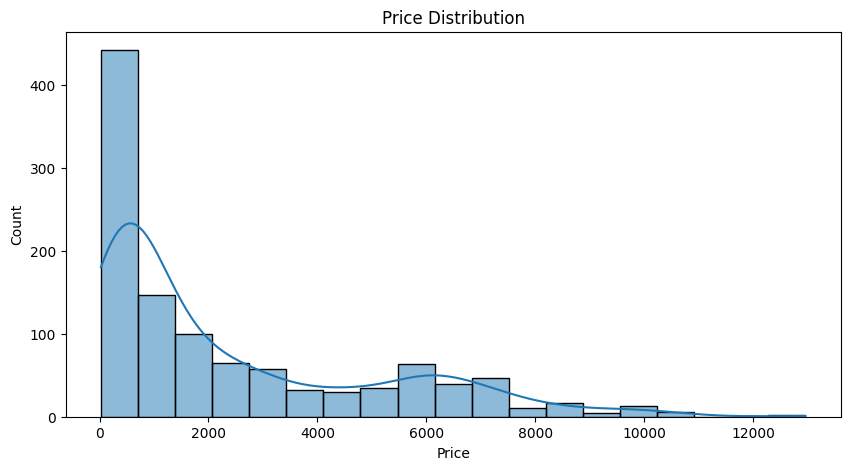

In [33]:
# Histogram for Price Distribution
# Shows How product prices are distributed (cheap vs expensive)
# Detect skewness & price concentration + possible outliers
plt.figure(figsize=(10,5))
sns.histplot(df["price"], kde=True)
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

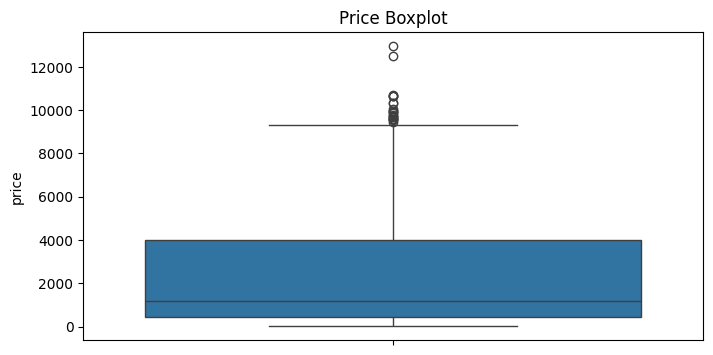

In [34]:
# Boxplot for Price Outliers
# Shows Extreme high or low prices (outliers)
# Helps detect incorrect prices or unusual expensive items
plt.figure(figsize=(8,4))
sns.boxplot(df["price"])
plt.title("Price Boxplot")
plt.show()

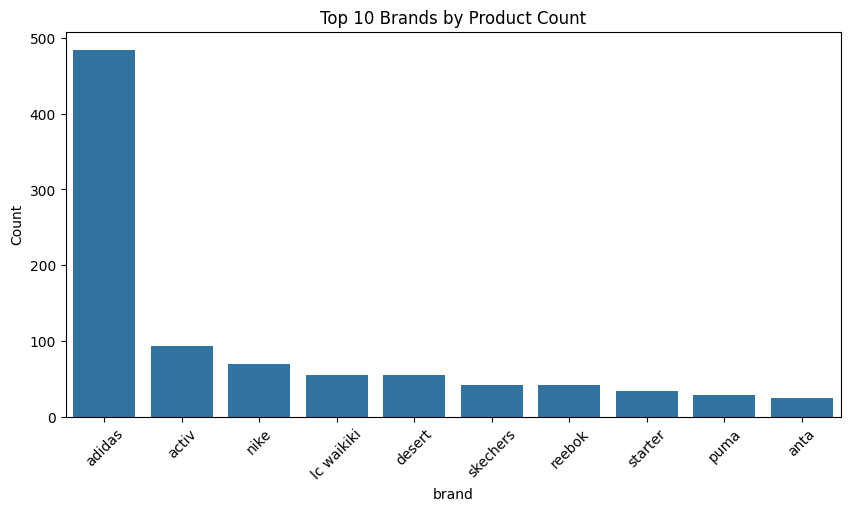

In [35]:
# Bar Chart for Top 10 Brands by Count
# Shows Most frequent brands in the dataset
# Understand market dominance & popular brands
top_brands = df["brand"].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_brands.index, y=top_brands.values)
plt.xticks(rotation=45)
plt.title("Top 10 Brands by Product Count")
plt.ylabel("Count")
plt.show()

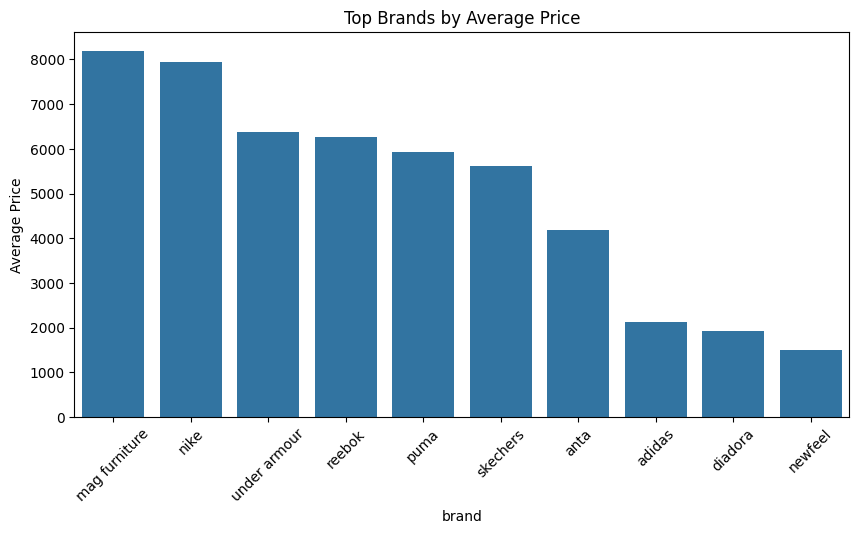

In [36]:
# Bar Chart for Average Price per Brand
# Shows Which brands have higher average price
# Understand pricing strategy differences between brands
avg_price = df.groupby("brand")["price"].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=avg_price.index, y=avg_price.values)
plt.xticks(rotation=45)
plt.ylabel("Average Price")
plt.title("Top Brands by Average Price")
plt.show()

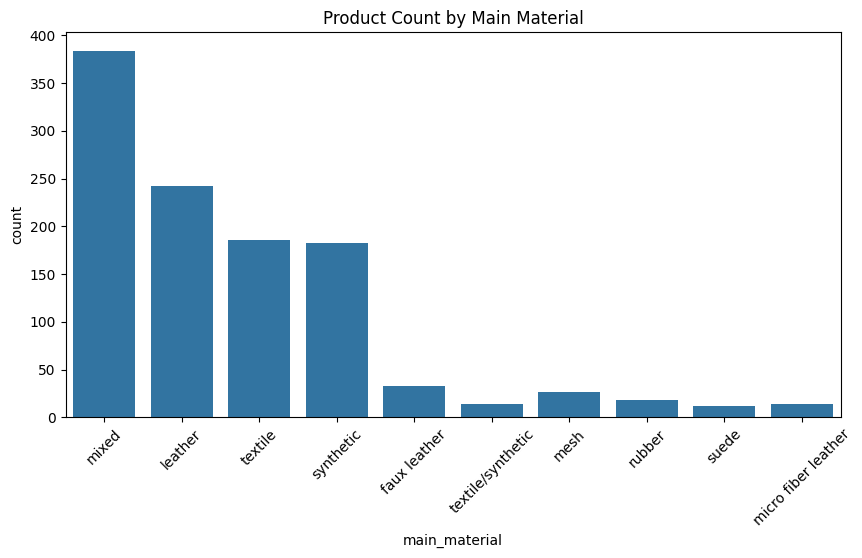

In [37]:
# Bar Chart for Material Frequency
# Shows How many shoes are made from each material
# Understand product manufacturing trends
plt.figure(figsize=(10,5))
sns.countplot(x="main_material", data=df)
plt.title("Product Count by Main Material")
plt.xticks(rotation=45)
plt.show()

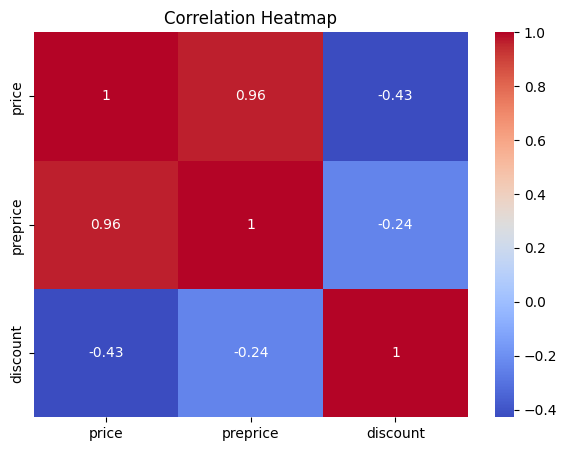

In [38]:
# Heatmap for Correlation between price, preprice & discount
# Shows Correlation strength between numeric variables
# Understand if expensive shoes get bigger discounts
corr = df[["price", "preprice", "discount"]].corr()
plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

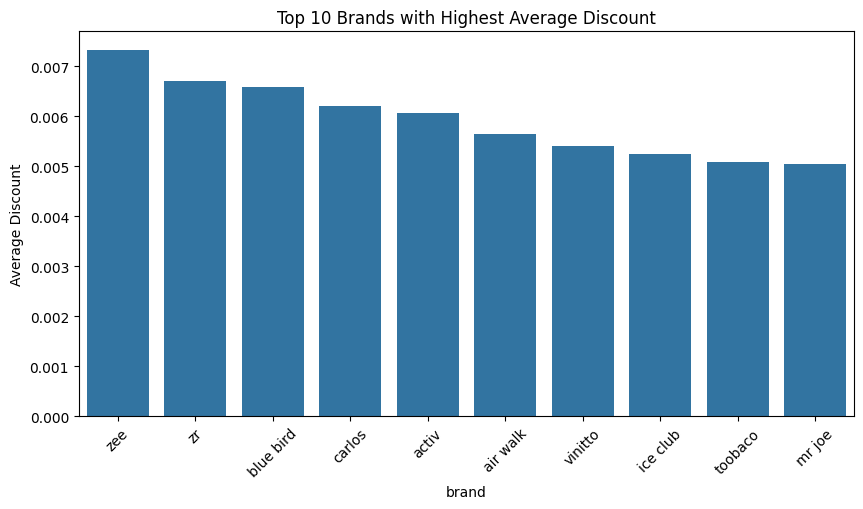

In [39]:
# Bar Chart for Average Discount per Brand
# Shows Which brands offer highest average discount
# Understand sales strategy per brand
avg_disc = df.groupby("brand")["discount"].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=avg_disc.index, y=avg_disc.values)
plt.title("Top 10 Brands with Highest Average Discount")
plt.xticks(rotation=45)
plt.ylabel("Average Discount")
plt.show()

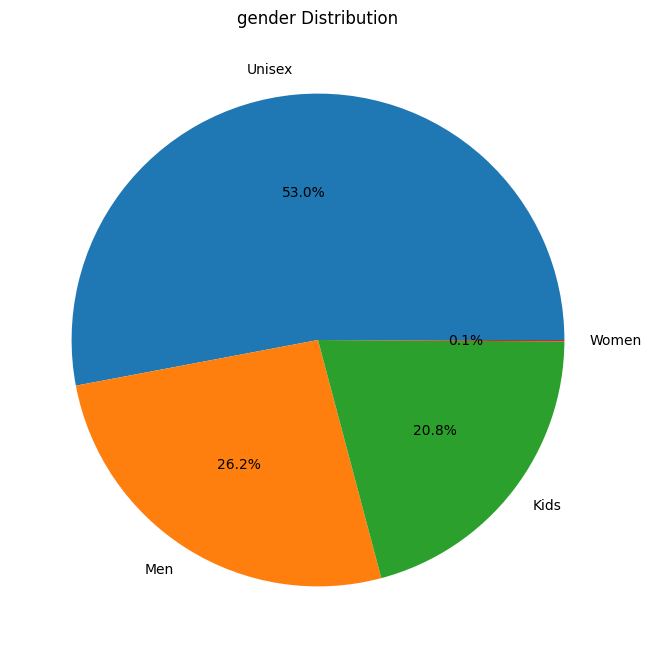

In [40]:
# Pie Chart for Distribution of gender
# Shows Percentage of shoes made from each gender
gender_counts = df["gender"].value_counts()
plt.figure(figsize=(8,8))
plt.pie(gender_counts.values, labels=gender_counts.index, autopct="%1.1f%%")
plt.title("gender Distribution")
plt.show()

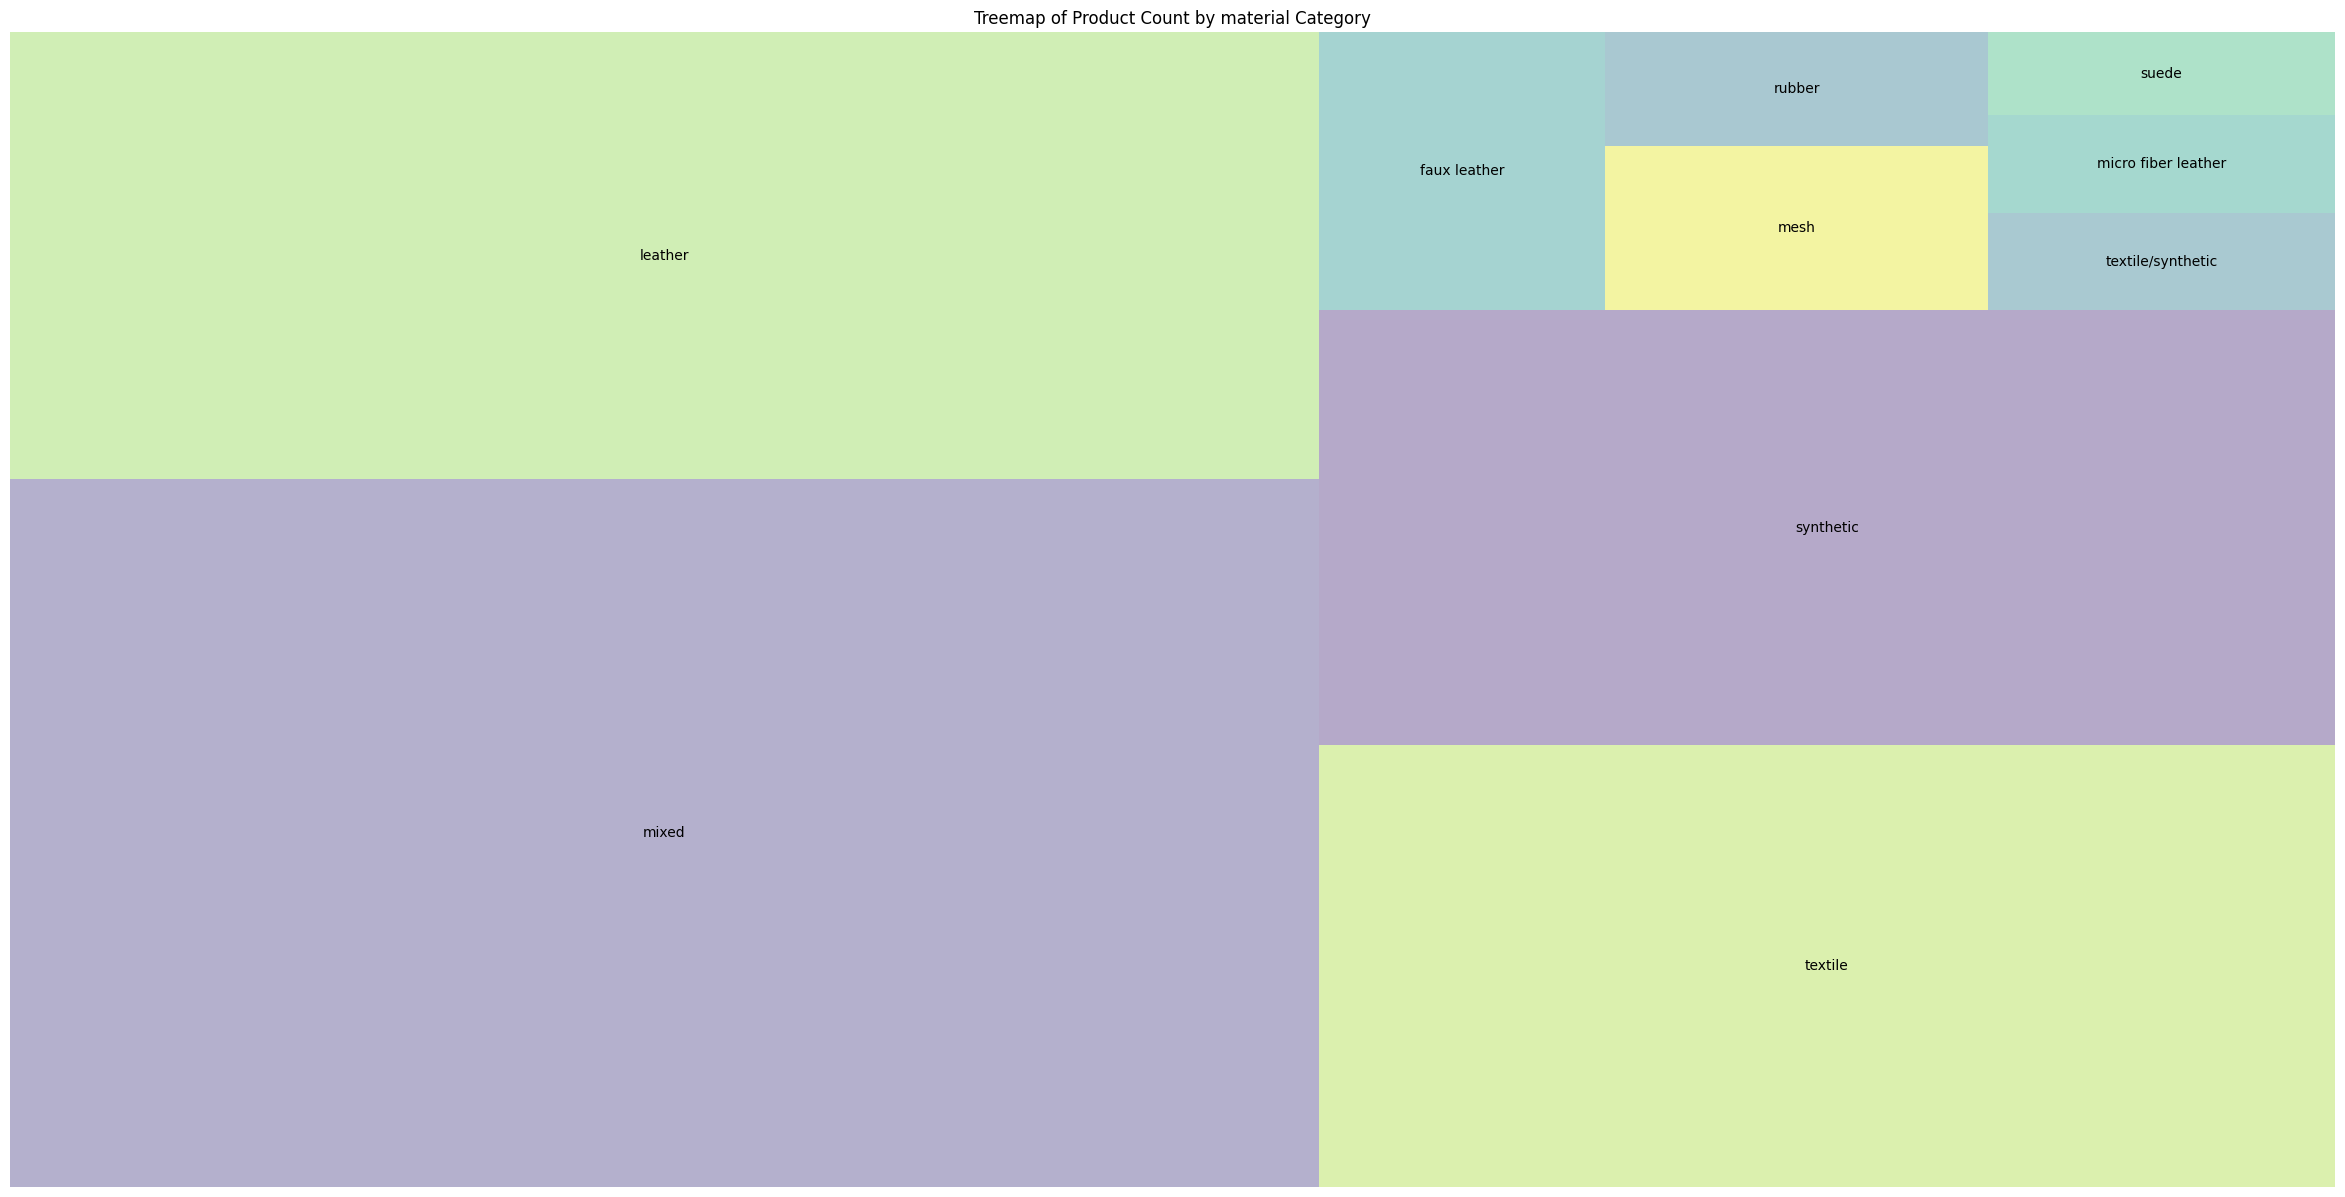

In [41]:
# Treemap for Count of Products by gender Category
# Shows How many products belong to gender
# Helps visualize category proportions
material_counts = df["main_material"].value_counts()
plt.figure(figsize=(30,15))
squarify.plot(
    sizes = material_counts.values,
    label = material_counts.index,
    alpha = 0.4
)
plt.title("Treemap of Product Count by material Category")
plt.axis('off')
plt.show()

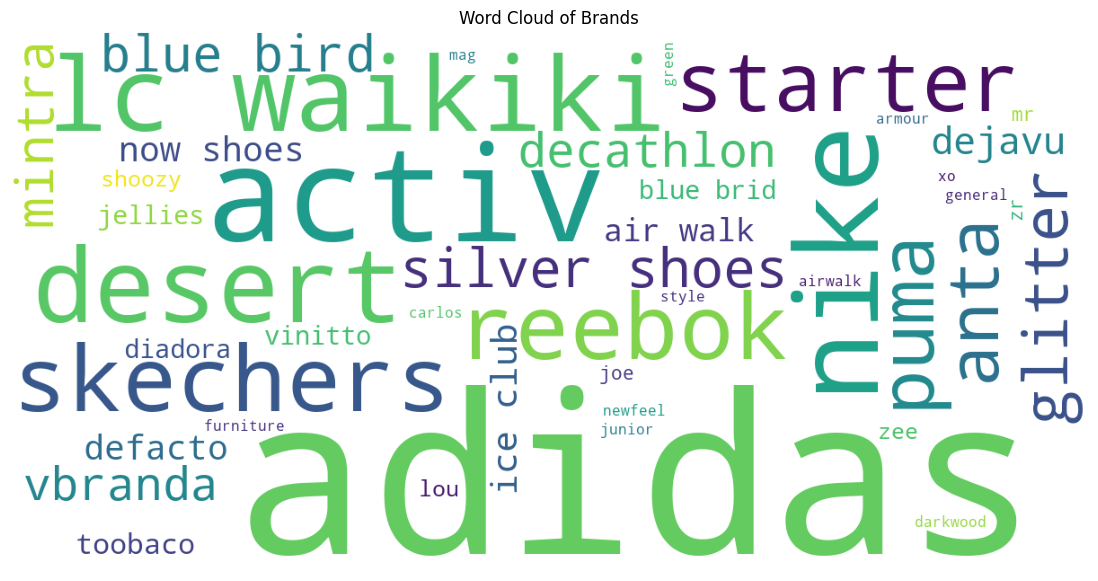

In [42]:
# Word Cloud for Popular Brands
# Shows Brands that appear the most (bigger word = more products)
# Helps visualize brand popularity quickly
brand_text = " ".join(df["brand"].astype(str))
wc = WordCloud(width=1200, height=600, background_color="white").generate(brand_text)
plt.figure(figsize=(15,7))
plt.imshow(wc)
plt.axis("off")
plt.title("Word Cloud of Brands")
plt.show()

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import joblib
import os

In [46]:
df = pd.read_csv("jumia_shoes_cleaned.csv")

In [47]:
label_cols = ["brand", "main_material", "gender"]
encoders = {}
for col in label_cols:
    encoders[col] = LabelEncoder()
    df[col] = encoders[col].fit_transform(df[col].astype(str))

In [48]:
df["price_minus_preprice"] = df["price"] - df["preprice"]
df["price_preprice_ratio"] = df["price"] / (df["preprice"] + 1)
df["preprice_per_discount"] = df["preprice"] / (df["discount"] + 1)

In [49]:
features = [
    "brand", "main_material", "gender",
    "preprice", "discount",
    "price_minus_preprice", "price_preprice_ratio", "preprice_per_discount"
]

In [50]:
X = df[features]
y = df["price"]

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
rf = RandomForestRegressor(n_estimators=400, max_depth=12, random_state=42)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

In [53]:
for train_idx, test_idx in cv.split(X):
    rf.fit(X.iloc[train_idx], y.iloc[train_idx])
    preds = rf.predict(X.iloc[test_idx])
    cv_scores.append(r2_score(y.iloc[test_idx], preds))

In [54]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", tree_method="hist")
param_dist = {
    "n_estimators": [250, 300, 350, 400],
    "learning_rate": [0.03, 0.05, 0.07],
    "max_depth": [3, 4, 5],
    "subsample": [0.6, 0.7, 0.9],
    "colsample_bytree": [0.6, 0.7, 0.9],
    "reg_alpha": [0, 0.1, 0.5],
    "reg_lambda": [1, 2, 3]
}
random_search = RandomizedSearchCV(
    xgb_model, param_distributions=param_dist, n_iter=20, scoring="r2", cv=5,
    verbose=1, random_state=42, n_jobs=-1
)
random_search.fit(X_train, y_train)
best_xgb_params = random_search.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [55]:
xgb_best = xgb.XGBRegressor(**best_xgb_params, objective="reg:squarederror")
xgb_best.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.9
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [56]:
rf_model = RandomForestRegressor(n_estimators=400, max_depth=12, random_state=42)
rf_model.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",400
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",12
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples 

In [57]:
def ensemble_predict(x):
    p1 = xgb_best.predict(x)
    p2 = rf_model.predict(x)
    p1 = np.log1p(p1)
    p2 = np.log1p(p2)
    avg = (p1 + p2) / 2
    return np.expm1(avg)

In [62]:
def metrics(model_name, y_true, y_pred):
    print(f"--- {model_name} ---")
    print("R2:", round(r2_score(y_true, y_pred), 4))
    print("MAE:", round(mean_absolute_error(y_true, y_pred), 2))
    print("RMSE:", round(np.sqrt(np.mean((y_true - y_pred) ** 2)), 2))


In [59]:
xgb_pred = xgb_best.predict(X_test)
rf_pred = rf_model.predict(X_test)
ens_pred = ensemble_predict(X_test)

In [63]:
metrics("XGBoost", y_test, xgb_pred)
metrics("RandomForest", y_test, rf_pred)
metrics("Ensemble", y_test, ens_pred)

--- XGBoost ---
R2: 0.9867
MAE: 96.31
RMSE: 319.2
--- RandomForest ---
R2: 0.9817
MAE: 93.03
RMSE: 373.47
--- Ensemble ---
R2: 0.9852
MAE: 90.26
RMSE: 336.57


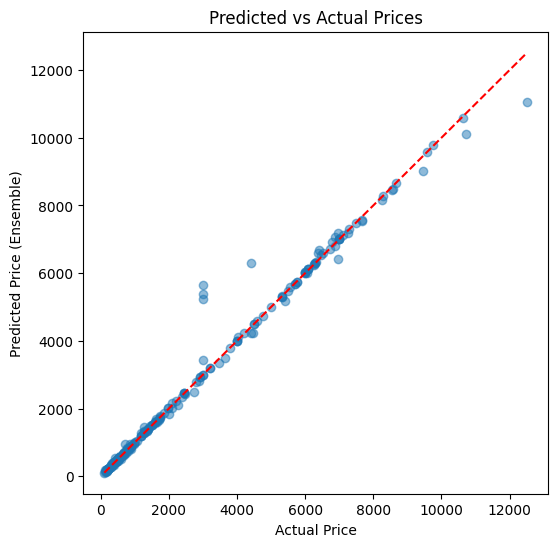

In [64]:
# === Plot 2: Predicted vs Actual Prices ===
plt.figure(figsize=(6,6))
plt.scatter(y_test, ens_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price (Ensemble)")
plt.title("Predicted vs Actual Prices")
plt.show()

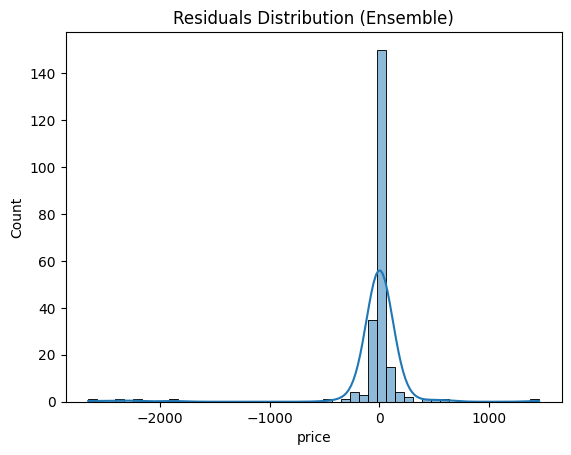

In [65]:
# === Plot 3: Residuals Histogram ===
residuals = y_test - ens_pred
sns.histplot(residuals, bins=50, kde=True)
plt.title("Residuals Distribution (Ensemble)")
plt.show()

In [66]:
os.makedirs("models", exist_ok=True)
joblib.dump(xgb_best, "./models/price_xgb.pkl")
joblib.dump(rf_model, "./models/price_rf.pkl")
joblib.dump(encoders, "./models/encoders.pkl")
joblib.dump(features, "./models/features.pkl")
joblib.dump({"xgb": xgb_best, "rf": rf_model}, "./models/ensemble_models.pkl")

['./models/ensemble_models.pkl']

In [67]:
def encode_value(col, value):
    value = value.strip().lower()
    classes = [c.lower() for c in encoders[col].classes_]
    if value not in classes:
        return encoders[col].transform(["unknown"])[0]
    original = encoders[col].classes_[classes.index(value)]
    return encoders[col].transform([original])[0]

In [70]:
def predict_price(brand, material, gender, preprice, discount):
    brand_enc = encode_value("brand", brand)
    material_enc = encode_value("main_material", material)
    gender_enc = encode_value("gender", gender)
    price_minus_pre = 0
    price_ratio = preprice / (preprice + 1)
    preprice_per_discount = preprice / (discount + 1)
    X = pd.DataFrame([{
        "brand": brand_enc,
        "main_material": material_enc,
        "gender": gender_enc,
        "preprice": preprice,
        "discount": discount,
        "price_minus_preprice": price_minus_pre,
        "price_preprice_ratio": price_ratio,
        "preprice_per_discount": preprice_per_discount
    }])
    xgb_p = xgb_best.predict(X)[0]
    rf_p = rf_model.predict(X)[0]
    final_p = (xgb_p + rf_p) / 2
    return xgb_p, rf_p, final_p

In [74]:
print("\n=== Ready For Prediction ===")
while True:
    print("\nEnter product info:\n")
    brand = input("Brand: ")
    material = input("Main Material: ")
    gender = input("Gender: ")
    preprice = float(input("Original price (preprice): "))
    discount = float(input("Discount %: "))
    xgb_p, rf_p, final_p = predict_price(brand, material, gender, preprice, discount)
    print("\nPredicted Price (XGBoost):", round(xgb_p, 2))
    print("Predicted Price (RandomForest):", round(rf_p, 2))
    print("Final Ensemble Prediction:", round(final_p, 2))
    cont = input("\nDo you want to predict again? (y/n): ").lower().strip()
    if cont != "y":
        print("Goodbye!")
        break


=== Ready For Prediction ===

Enter product info:


Predicted Price (XGBoost): 804.7
Predicted Price (RandomForest): 761.85
Final Ensemble Prediction: 783.28
Goodbye!
